In [9]:
import ast

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import wandb

from nle.dataset import db

In [10]:
api = wandb.Api()

### Prepare data from experiments

In [11]:
keys = [
    "policy_stats/avg_score", 
    "policy_stats/avg_experience_points", 
    # "policy_stats/avg_experience_level", 
    # "policy_stats/avg_max_energy", 
    # "policy_stats/avg_max_hitpoints", 
    "policy_stats/avg_eating_score", 
    "policy_stats/avg_turns", 
    "policy_stats/avg_staircase_score", 
    # "policy_stats/avg_staircase_pet_score", 
    # "policy_stats/avg_armor_class", 
    "policy_stats/avg_scout_score", 
    "policy_stats/avg_dlvl", 
    # "policy_stats/avg_sokobanfillpit_score", 
    "policy_stats/avg_gold_score", 
    "train/env_steps",
]

In [12]:
def get_experiment_data(filters, name, keys):
    runs = api.runs("bartekcupial/sf2_nethack", filters=filters)
    data = []
    for run in runs:
        try:
            df = {key: run.summary[key] for key in keys}
            df = pd.DataFrame(df)
            df["seed"] = run.config["seed"]
            df["train/env_steps"] = run.summary_metrics["train/env_steps"]
            df["name"] = name
            df["exp_tag"] = ast.literal_eval(run.config["exp_tags"])[0]
            
            df = df.assign(ItemList=df[keys[0]].apply(lambda x: [x] if isinstance(x, int) else x)).explode('ItemList')
            del df["ItemList"]
            
            data.append(df)
        except Exception as e:
            pass

    df = pd.concat(data, axis=0).reset_index()
    df.reset_index(drop=True, inplace=True)
    return df

In [13]:
data = []
for exp_tag, name in zip(
    [
        "['2024_01_28_eval_APPO']", 
        "['2024_01_28_eval_APPO-T']", 
        "['2024_01_28_eval_APPO-KS-T']", 
        "['2024_01_28_eval_APPO-BC-T']",
    ],
    [
        "appo", 
        "appo_t", 
        "appo_ks_t", 
        "appo_bc_t",
    ],
):
    df = get_experiment_data({"config.exp_tags": exp_tag}, name, ["reward_p0", "dlvl_p0", "turns_p0"])
    data.append(df)

    
data = pd.concat(data, axis=0).reset_index()

In [14]:
data["index"] = data["train/env_steps"] - data["train/env_steps"] % 5_000_000

In [15]:
data = data[data["index"] == 500_000_000]

### Prepare data from NLD-AA

In [16]:
def get_dataset_stats(dataset_name, dbfilename=db.DB):
    sql_args = (dataset_name,)
    
    sql = """
    SELECT games.gameid, games.points, games.turns, games.maxlvl
    FROM games
    INNER JOIN datasets ON games.gameid=datasets.gameid
    WHERE datasets.dataset_name=? AND games.role='Mon' AND games.race='Hum'"""

    with db.connect(dbfilename) as conn:
        data = list(conn.execute(sql, sql_args))
        stats = pd.DataFrame(data, columns=["gameid", "points", "turns", "maxlvl"])
    return stats

In [17]:
dbfilename = "/home/bartek/Workspace/data/nethack/AANAO/ttyrecs.db"

In [18]:
df = get_dataset_stats("autoascend", dbfilename)

In [19]:
df = df.drop(columns=["gameid"])

In [20]:
df = df.rename(columns={'points': 'reward_p0', "turns": "turns_p0", "maxlvl": "dlvl_p0"})

In [21]:
df["name"] = "autoascend"
df["exp_tag"] = "autoascend"
df["index"] = 0
df["train/env_steps"] = 0
df["seed"] = 0

In [22]:
data = pd.concat([df, data])

### Prepare data from pretrained policy

In [23]:
df = pd.read_csv("notebooks/cloned_expert_1024_human_monk.csv")

In [24]:
df = df[["reward", "turns", "dlvl"]]
df = df.rename(columns={'reward': 'reward_p0', "turns": "turns_p0", "dlvl": "dlvl_p0"})

In [25]:
df["name"] = "pretrained"
df["exp_tag"] = "pretrained"
df["index"] = 0
df["train/env_steps"] = 0
df["seed"] = 0

In [26]:
data = pd.concat([df, data])

### Prepare 1000 samples from APPO-KS

In [27]:
df = []
for path in Path("notebooks/data").iterdir():
    df.append(pd.read_csv(path))
df = pd.concat(df, axis=0)

In [28]:
df = df[["reward", "turns", "dlvl"]]
df = df.rename(columns={'reward': 'reward_p0', "turns": "turns_p0", "dlvl": "dlvl_p0"})

In [29]:
df["name"] = "appo_ks_t_big"
df["exp_tag"] = "appo_ks_t_big"
df["index"] = 0
df["train/env_steps"] = 0
df["seed"] = 0

In [30]:
data = pd.concat([df, data])

### Visualize the data

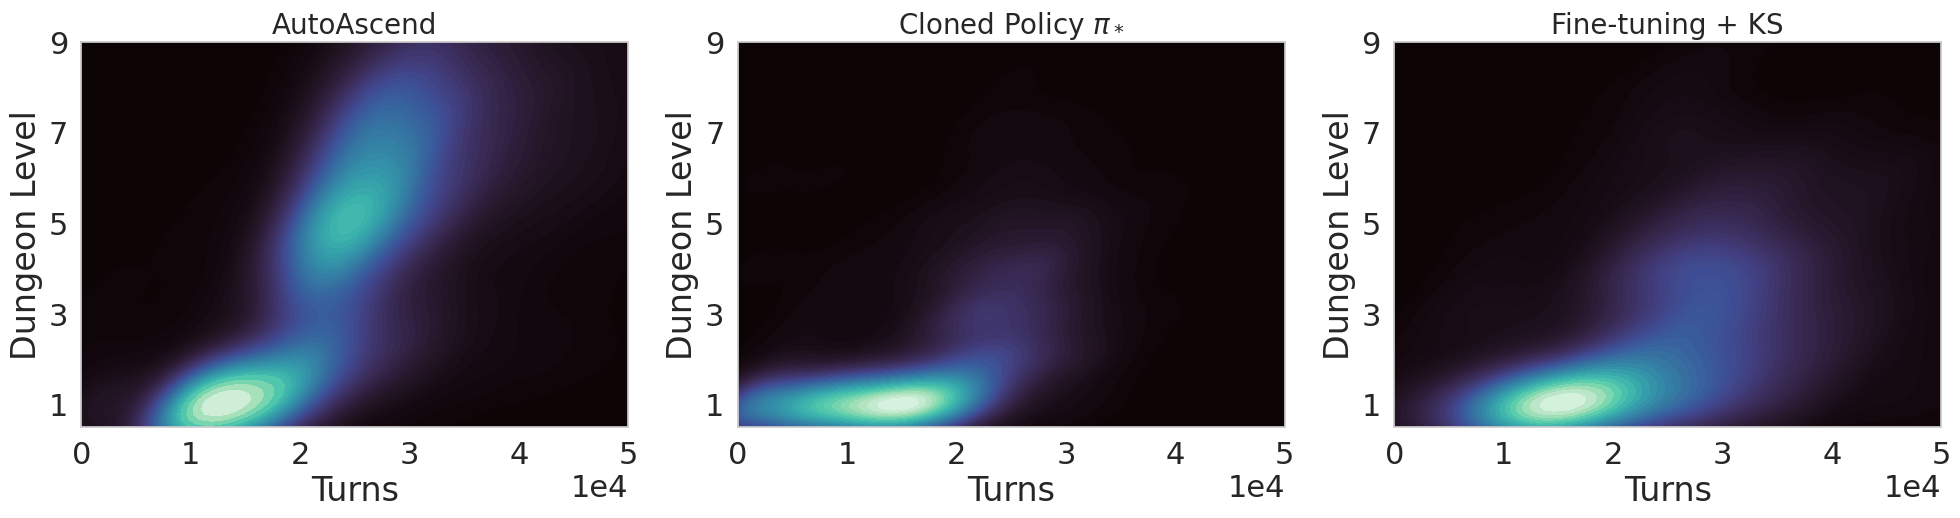

In [32]:
sns.set(font_scale=2)
sns.set_style("whitegrid")

n_rows = 1
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 5))
axes = axes.flatten()

sns.set(font_scale=3)
sns.set_style('whitegrid')

method_translator = {
    "autoascend": "AutoAscend",
    "pretrained": "Cloned Policy $\pi_*$",
    "appo_ks_t_big": "Fine-tuning + KS",
    # "appo_bc_t": "Fine-tuning + BC",
    # "appo": "From Scratch",
    # "appo_t": "Fine-tuning",
}

eval_y = "dlvl_p0"
eval_x = "turns_p0"

for e, (ax, (method, method_name)) in enumerate(zip(axes, method_translator.items())):
    method_data = data[data["name"] == method]

    sns.kdeplot(x=eval_x, y=eval_y, data=method_data, thresh=0, levels=50, cmap="mako", fill=True, ax=ax, label=method_name)
    ax.set_ylim(0.5, 9.0)
    ax.set_xlim(0, 50000.0)
    
    ax.set_title(f"{method_name}", fontsize=20)
    ax.set_ylabel("Dungeon Level")
    ax.set_xlabel("Turns")
    
    ax.set_yticks(ticks=range(1, 9 + 1, 2))
    ax.set_xticks(ticks=range(0, 50000 + 1, 10000))
    
    ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
# plt.tight_layout()
plt.show()